# Day 1: Probability Distributions in Finance

## Week 2 - Statistics & Probability for Quantitative Finance

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation

---

### 🎯 Learning Objectives
- Understand key probability distributions used in finance
- Fit distributions to real financial data
- Compare Normal vs Student-t for modeling returns
- Quantify tail risk using distribution parameters

---

### 📈 Why Probability Distributions Matter in Trading

**What is a Probability Distribution?**
A probability distribution describes how likely different outcomes are. In trading, it tells us the likelihood of different return values occurring.

**Trading Applications:**

| Use Case | How Distributions Help |
|----------|------------------------|
| **Risk Management** | Calculate VaR, Expected Shortfall to know maximum potential loss |
| **Position Sizing** | Determine how much capital to allocate based on risk |
| **Option Pricing** | Black-Scholes assumes log-normal prices |
| **Strategy Backtesting** | Understand if returns are realistic or overfit |
| **Stress Testing** | Model extreme scenarios (tail events) |

---

### 🔍 When to Use This:
- When your risk model seems to underestimate losses
- When pricing derivatives or structured products
- When setting stop-losses and position sizes
- Before allocating capital to a new strategy

### ⚠️ Real-World Impact:
- Long-Term Capital Management (LTCM) collapsed partly due to assuming Normal returns
- In 2008, banks using Normal distribution VaR underestimated risk by 3-5x

In [1]:
# Day 1 Setup: Probability Distributions in Finance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("PROBABILITY DISTRIBUTIONS IN FINANCE - DAY 1")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days")
print(f"Data: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns):,}")
print(f"Assets: {', '.join(returns.columns)}")

📥 Downloading data from Yahoo Finance...
PROBABILITY DISTRIBUTIONS IN FINANCE - DAY 1

✅ Data loaded: 1254 days
Data: 2021-01-26 to 2026-01-21
Observations: 1,253
Assets: AAPL, GOOGL, GS, JPM, MSFT


## 1. The Normal Distribution - Foundation & Limitations

### What is the Normal Distribution?
The **Normal (Gaussian) distribution** is a bell-shaped curve that describes data clustering around a mean value. It's the most common assumption in finance.

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

### Key Properties
| Property | Value | Trading Meaning |
|----------|-------|----------------|
| 68% within ±1σ | ~68% of days | Normal trading days |
| 95% within ±2σ | ~95% of days | Unusual but expected moves |
| 99.7% within ±3σ | ~99.7% of days | Rare events (~3 per year) |

### 🎯 Trading Applications

1. **Simple VaR Calculation**: If daily σ = 2%, then 95% VaR ≈ 2% × 1.65 = 3.3%- ❌ **Avoid**: Risk management for leveraged positions, tail risk hedging

2. **Bollinger Bands**: Use ±2σ bands to identify overbought/oversold- ✅ **Use**: Quick estimates, educational purposes, stable markets

3. **Position Sizing**: Kelly Criterion assumes normal returns### When to Use vs Avoid

4. **Option Greeks**: Delta, Gamma derived assuming normality

| Constant volatility | Vol clusters (high vol follows high vol) | Risk changes over time |

### ⚠️ Why It Fails in Real Trading| Thin tails | "Black Swan" events occur more often | 3σ events happen 10x more than predicted |

| Assumption | Reality | Impact || Symmetric tails | Markets crash faster than rally | Underestimates downside risk |
|------------|---------|--------|

FITTING NORMAL DISTRIBUTION TO AAPL RETURNS

Estimated Parameters:
  Mean (μ):     0.000612 (15.41% annualized)
  Std Dev (σ):  0.017439 (27.68% annualized)

Normality Test (D'Agostino-Pearson):
  Test statistic: 222.1074
  P-value:        0.000000
  Conclusion:     NOT Normal (α=0.05)


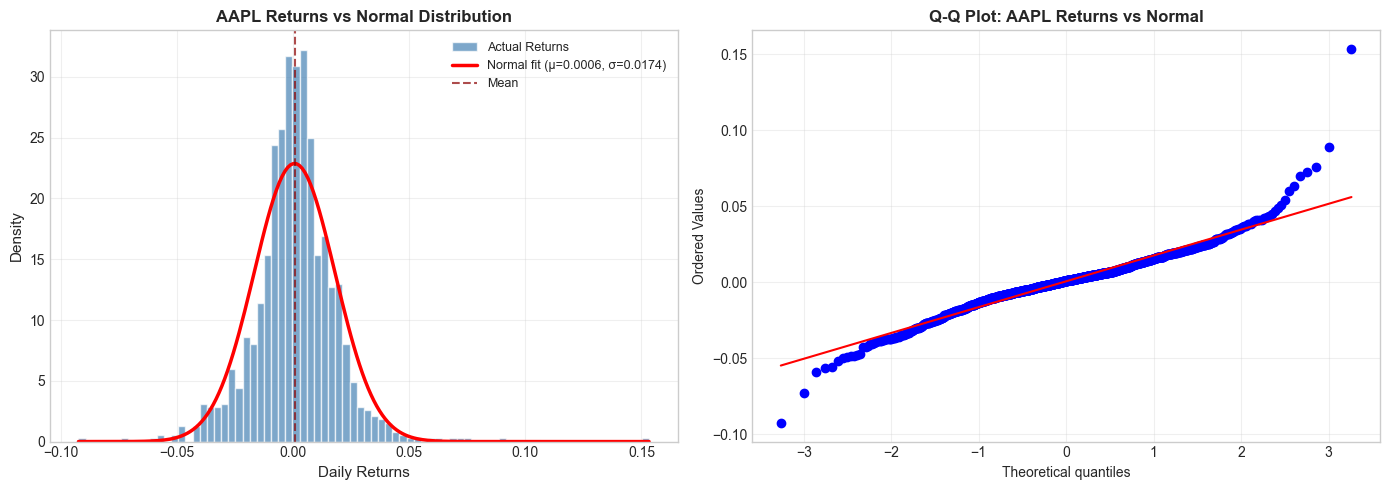


📊 Q-Q Plot Interpretation:
   - Points on diagonal → Normal distribution
   - Curved tails → Fat tails (common in finance)
   - S-shape → Skewness


In [2]:
# Fit Normal distribution to AAPL returns
aapl_returns = returns['AAPL'].values

# Calculate Normal parameters (MLE)
mu_normal = np.mean(aapl_returns)
sigma_normal = np.std(aapl_returns)

print("=" * 60)
print("FITTING NORMAL DISTRIBUTION TO AAPL RETURNS")
print("=" * 60)
print(f"\nEstimated Parameters:")
print(f"  Mean (μ):     {mu_normal:.6f} ({mu_normal * 252:.2%} annualized)")
print(f"  Std Dev (σ):  {sigma_normal:.6f} ({sigma_normal * np.sqrt(252):.2%} annualized)")

# Create fitted distribution
normal_dist = stats.norm(loc=mu_normal, scale=sigma_normal)

# Test goodness of fit
stat, p_value = stats.normaltest(aapl_returns)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Test statistic: {stat:.4f}")
print(f"  P-value:        {p_value:.6f}")
print(f"  Conclusion:     {'Normal' if p_value > 0.05 else 'NOT Normal'} (α=0.05)")

# Visualize fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with Normal fit
x_range = np.linspace(aapl_returns.min(), aapl_returns.max(), 200)
axes[0].hist(aapl_returns, bins=80, density=True, alpha=0.7, 
             color='steelblue', edgecolor='white', label='Actual Returns')
axes[0].plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2.5, 
             label=f'Normal fit (μ={mu_normal:.4f}, σ={sigma_normal:.4f})')
axes[0].axvline(mu_normal, color='darkred', linestyle='--', alpha=0.7, label='Mean')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('AAPL Returns vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Q-Q Plot - visual normality test
stats.probplot(aapl_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: AAPL Returns vs Normal', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Q-Q Plot Interpretation:")
print("   - Points on diagonal → Normal distribution")
print("   - Curved tails → Fat tails (common in finance)")
print("   - S-shape → Skewness")

## 2. Student-t Distribution - Capturing Fat Tails

### What is the Student-t Distribution?
The **Student-t distribution** looks like a Normal but with "fatter" tails - meaning extreme events (both gains and losses) are more likely.

$$f(x) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

### Key Parameter: Degrees of Freedom (ν or df)
| df Value | Tail Behavior | Typical Asset |
|----------|---------------|---------------|
| df = 3-4 | Very fat tails | Individual stocks, crypto |
| df = 5-7 | Moderate fat tails | Stock indices |
| df = 10-15 | Slightly fat tails | Bonds, stable FX |
| df → ∞ | Normal distribution | Theoretical only |


### 🎯 Trading Applications- This matches actual market data much better!

1. **Better VaR Estimates**: Student-t VaR is 20-50% higher than Normal VaR at 99% level- Student-t (df=4) says it happens once every 2-3 years

2. **Options Trading**: Explains why out-of-money puts are expensive (tail risk premium)If Normal predicts a 5% daily loss happens once in 20 years:

3. **Risk Budgeting**: Allocate more capital buffer for fat-tailed assets### Real Example

4. **Stress Testing**: More realistic extreme scenario modeling

- ❌ **Avoid when**: Quick calculations, very short time horizons

### When to Use Student-t- ✅ **Use for**: Individual stocks, emerging markets, leveraged strategies
- ✅ **Use when**: Managing tail risk, pricing options, regulatory capital

FITTING STUDENT-T DISTRIBUTION TO AAPL RETURNS

Estimated Parameters:
  Degrees of Freedom (ν): 3.86
  Location (μ):           0.000767
  Scale (σ):              0.012364

💡 df = 3.9 indicates heavy tails
   (Lower df = heavier tails, df → ∞ = Normal)

TAIL PROBABILITY COMPARISON (Extreme Events)

Event                     Normal          Student-t       Actual    
-----------------------------------------------------------------
Return < -2σ (-3.427%)    0.022750      0.024553        0.031923
Return < -3σ (-5.171%)    0.001350      0.007114        0.004789
Return < -4σ (-6.915%)    0.000032      0.002672        0.001596
Return < -5σ (-8.658%)    0.000000      0.001204        0.000798


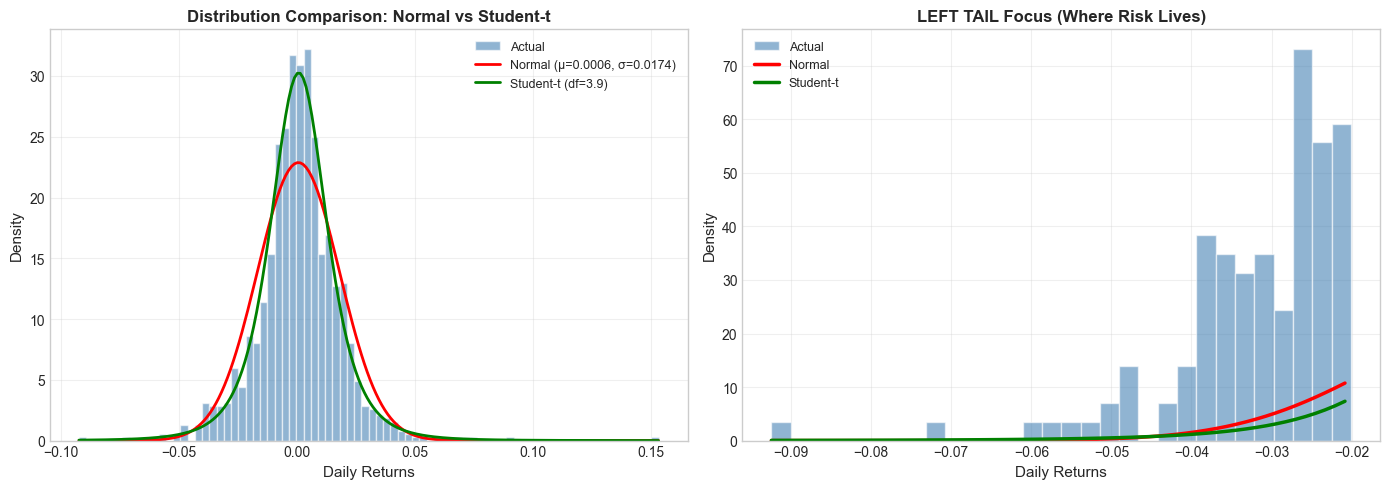


📈 Key Insight: Student-t captures tail events that Normal misses!


In [3]:
# Fit Student-t distribution to AAPL returns
# MLE estimation of df, loc, scale
df_t, loc_t, scale_t = stats.t.fit(aapl_returns)

print("=" * 60)
print("FITTING STUDENT-T DISTRIBUTION TO AAPL RETURNS")
print("=" * 60)
print(f"\nEstimated Parameters:")
print(f"  Degrees of Freedom (ν): {df_t:.2f}")
print(f"  Location (μ):           {loc_t:.6f}")
print(f"  Scale (σ):              {scale_t:.6f}")
print(f"\n💡 df = {df_t:.1f} indicates {'heavy' if df_t < 5 else 'moderate'} tails")
print(f"   (Lower df = heavier tails, df → ∞ = Normal)")

# Create fitted distribution
t_dist = stats.t(df=df_t, loc=loc_t, scale=scale_t)

# Compare Normal vs Student-t in the tails
print("\n" + "=" * 60)
print("TAIL PROBABILITY COMPARISON (Extreme Events)")
print("=" * 60)

# Calculate probability of extreme events
thresholds = [2, 3, 4, 5]  # Standard deviations
print(f"\n{'Event':<25} {'Normal':<15} {'Student-t':<15} {'Actual':<10}")
print("-" * 65)

for n_std in thresholds:
    threshold = mu_normal - n_std * sigma_normal
    p_normal = normal_dist.cdf(threshold)
    p_t = t_dist.cdf(threshold)
    p_actual = (aapl_returns < threshold).mean()
    
    print(f"Return < -{n_std}σ ({threshold:.3%})"
          f"    {p_normal:.6f}      {p_t:.6f}        {p_actual:.6f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDF comparison
axes[0].hist(aapl_returns, bins=80, density=True, alpha=0.6, 
             color='steelblue', edgecolor='white', label='Actual')
axes[0].plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2, 
             label=f'Normal (μ={mu_normal:.4f}, σ={sigma_normal:.4f})')
axes[0].plot(x_range, t_dist.pdf(x_range), 'g-', lw=2, 
             label=f'Student-t (df={df_t:.1f})')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Distribution Comparison: Normal vs Student-t', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Focus on left tail (risk perspective)
left_tail = x_range[x_range < -0.02]
axes[1].hist(aapl_returns[aapl_returns < -0.02], bins=30, density=True, 
             alpha=0.6, color='steelblue', edgecolor='white', label='Actual')
axes[1].plot(left_tail, normal_dist.pdf(left_tail), 'r-', lw=2.5, label='Normal')
axes[1].plot(left_tail, t_dist.pdf(left_tail), 'g-', lw=2.5, label='Student-t')
axes[1].set_xlabel('Daily Returns', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('LEFT TAIL Focus (Where Risk Lives)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key Insight: Student-t captures tail events that Normal misses!")

## 3. Log-Normal Distribution - Modeling Prices

### What is the Log-Normal Distribution?
The **Log-Normal distribution** describes a variable whose logarithm is normally distributed. Since stock prices can't go negative but can grow infinitely, this is the standard model for price evolution.

$$\ln(P_t) \sim N(\mu, \sigma^2)$$

### Why Prices are Log-Normal (not Normal)
| Property | Normal Prices | Log-Normal Prices |
|----------|---------------|-------------------|
| Can be negative? | Yes ❌ | No ✅ |
| Percentage returns | Asymmetric | Symmetric ✅ |
| Compound growth | Not modeled | Naturally modeled ✅ |


### 🎯 Trading Applications| Log | $\ln(P_t/P_{t-1})$ | Time-series analysis, compounding |

1. **Black-Scholes Option Pricing**: The entire model assumes log-normal prices| Simple | $(P_t - P_{t-1})/P_{t-1}$ | Portfolio returns, short periods |

2. **Monte Carlo Simulation**: Generate realistic price paths using GBM|-------------|---------|-------------|

3. **Long-term Projections**: Compound returns over months/years| Return Type | Formula | When to Use |

4. **Portfolio Growth**: Model wealth evolution over time### Simple vs Log Returns



### Geometric Brownian Motion (GBM)- ❌ **Avoid for**: Very short-term (intraday) where simple returns ≈ log returns

The foundation of quantitative finance:- ✅ **Use when**: Compounding matters (multi-period analysis)

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$- ✅ **Use for**: Price modeling, option pricing, long-horizon forecasts

### When to Use Log-Normal

- $\mu$ = drift (expected return)

- $\sigma$ = volatility- $dW_t$ = random Brownian motion

LOG-NORMAL DISTRIBUTION FOR PRICES

Log-Return Parameters:
  Mean (μ):   0.000460 (11.60% annualized)
  Std (σ):    0.017379 (27.59% annualized)

Normality Comparison:
  Simple returns p-value: 5.888348e-49
  Log returns p-value:    1.295397e-38
  Winner: Log returns (closer to Normal)


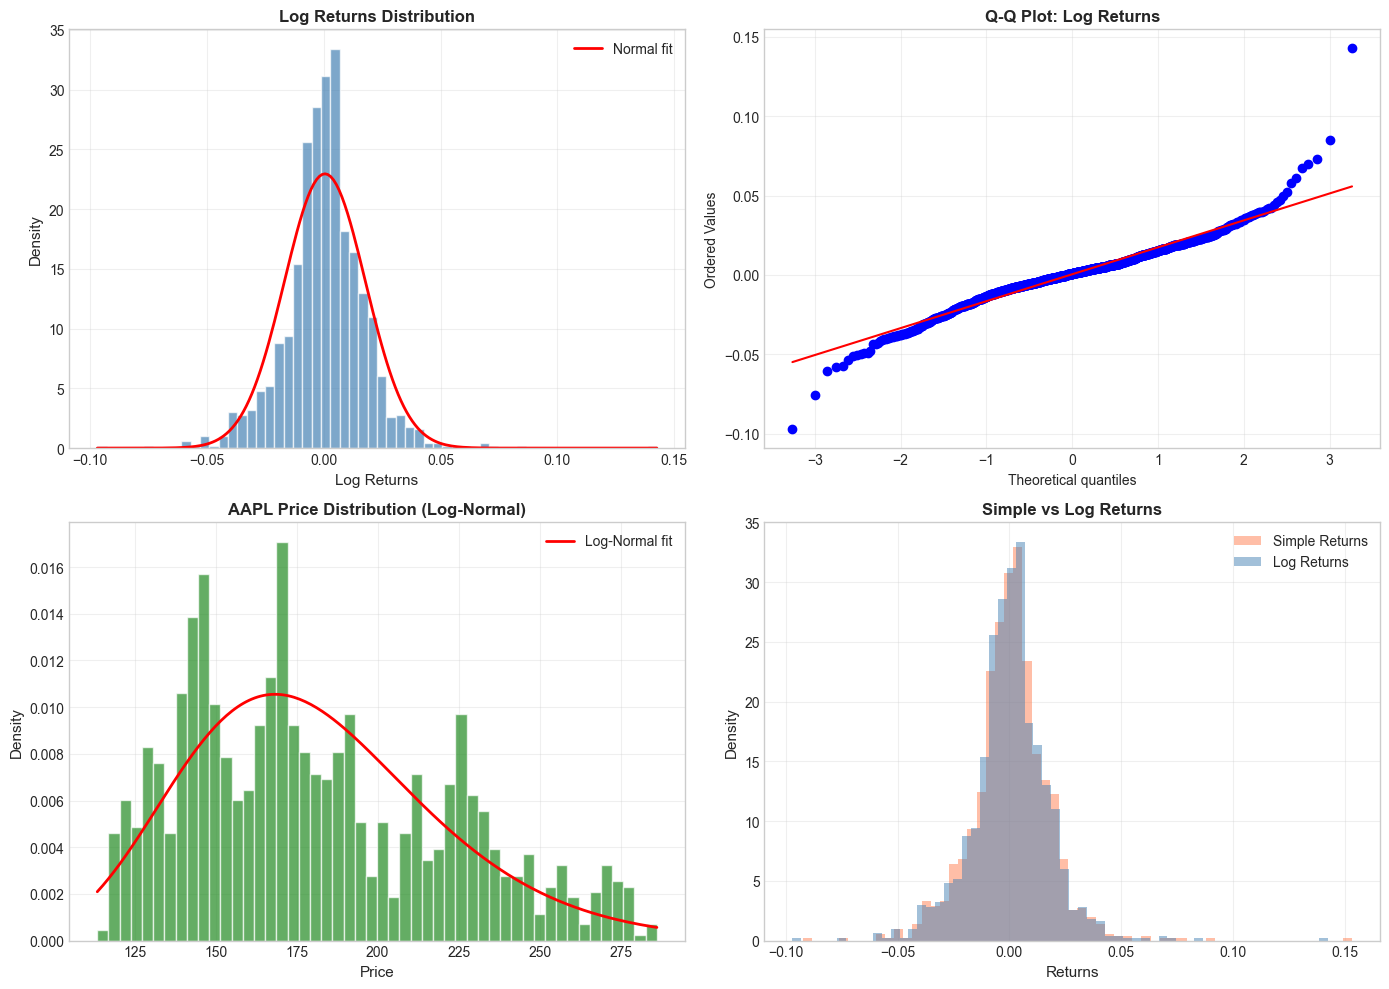


📊 Key Insight: Log returns ≈ Simple returns for small values
   but diverge for large moves. Both are NOT perfectly Normal!


In [4]:
# Log-Normal Distribution for Prices
aapl_prices = prices['AAPL'].values

# Calculate log returns
log_returns = np.log(prices['AAPL'] / prices['AAPL'].shift(1)).dropna().values

print("=" * 60)
print("LOG-NORMAL DISTRIBUTION FOR PRICES")
print("=" * 60)

# Fit normal to log-returns
mu_log = np.mean(log_returns)
sigma_log = np.std(log_returns)

print(f"\nLog-Return Parameters:")
print(f"  Mean (μ):   {mu_log:.6f} ({mu_log * 252:.2%} annualized)")
print(f"  Std (σ):    {sigma_log:.6f} ({sigma_log * np.sqrt(252):.2%} annualized)")

# Test if log-returns are more Normal than simple returns
stat_simple, p_simple = stats.normaltest(aapl_returns)
stat_log, p_log = stats.normaltest(log_returns)

print(f"\nNormality Comparison:")
print(f"  Simple returns p-value: {p_simple:.6e}")
print(f"  Log returns p-value:    {p_log:.6e}")
print(f"  Winner: {'Log returns' if p_log > p_simple else 'Simple returns'} (closer to Normal)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Log returns histogram
axes[0, 0].hist(log_returns, bins=60, density=True, alpha=0.7, 
                color='steelblue', edgecolor='white')
x_log = np.linspace(log_returns.min(), log_returns.max(), 200)
axes[0, 0].plot(x_log, stats.norm.pdf(x_log, mu_log, sigma_log), 
                'r-', lw=2, label='Normal fit')
axes[0, 0].set_xlabel('Log Returns', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Log Returns Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot for log returns
stats.probplot(log_returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Log Returns', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Price distribution (should be log-normal)
axes[1, 0].hist(aapl_prices, bins=50, density=True, alpha=0.7, 
                color='forestgreen', edgecolor='white')
# Fit log-normal to prices
shape, loc, scale = stats.lognorm.fit(aapl_prices, floc=0)
x_price = np.linspace(aapl_prices.min(), aapl_prices.max(), 200)
axes[1, 0].plot(x_price, stats.lognorm.pdf(x_price, shape, loc, scale), 
                'r-', lw=2, label='Log-Normal fit')
axes[1, 0].set_xlabel('Price', fontsize=11)
axes[1, 0].set_ylabel('Density', fontsize=11)
axes[1, 0].set_title('AAPL Price Distribution (Log-Normal)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Simple vs Log returns comparison
axes[1, 1].hist(aapl_returns, bins=60, density=True, alpha=0.5, 
                color='coral', label='Simple Returns')
axes[1, 1].hist(log_returns, bins=60, density=True, alpha=0.5, 
                color='steelblue', label='Log Returns')
axes[1, 1].set_xlabel('Returns', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title('Simple vs Log Returns', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: Log returns ≈ Simple returns for small values")
print("   but diverge for large moves. Both are NOT perfectly Normal!")

## 4. VaR: Practical Application of Distributions

### What is Value at Risk (VaR)?
**VaR** answers: "What's the maximum I could lose with X% confidence over Y time period?"

$$\text{VaR}_\alpha = F^{-1}(\alpha)$$

### Example Interpretation
"95% 1-day VaR of $50,000" means:
- There's a 5% chance of losing MORE than $50,000 tomorrow
- On 95% of days, losses will be less than $50,000
- On average, once per month you might exceed this loss

3. **Not sub-additive**: Portfolio VaR can exceed sum of individual VaRs

### 🎯 Trading Applications2. **Assumes past = future** which fails in regime changes

| Use Case | How VaR Helps |1. **Doesn't tell you HOW BAD** losses can be beyond VaR

|----------|---------------|### ⚠️ VaR Limitations

| **Position Sizing** | Don't risk more than X% of portfolio per trade |

| **Margin Requirements** | Brokers set margin based on VaR |- ✅ **Historical VaR**: Regulatory reporting, backtesting

| **Risk Limits** | Trading desks have daily VaR limits |- ✅ **Student-t VaR**: Actual risk management, volatile assets

| **Regulatory Capital** | Banks must hold capital = 3× VaR |- ✅ **Normal VaR**: Internal quick checks, stable assets

| **Performance Attribution** | Did we take appropriate risk for returns? |### When to Use Each VaR Type



### VaR Calculation Methods| **Monte Carlo** | Most flexible | Computationally expensive | Complex portfolios |

| Method | Pros | Cons | Best For || **Historical** | No distribution assumption | Needs lots of data | Regulatory compliance |

|--------|------|------|----------|| **Parametric (Student-t)** | Captures fat tails | Slightly complex | Better risk management |
| **Parametric (Normal)** | Fast, simple | Underestimates tail risk | Quick estimates |

VALUE AT RISK (VaR) - DISTRIBUTION COMPARISON

Portfolio Value: $1,000,000

------------------------------------------------------------
Confidence      Historical      Normal          Student-t      
------------------------------------------------------------
99% VaR         -4.24%          -4.00%          -4.65%
95% VaR         -2.81%          -2.81%          -2.59%
90% VaR         -1.93%          -2.17%          -1.83%

VaR IN DOLLAR TERMS (1-Day)

Confidence      Historical      Normal          Student-t      
------------------------------------------------------------
99% VaR         $    42,399     $    39,958     $    46,473
95% VaR         $    28,069     $    28,073     $    25,859
90% VaR         $    19,335     $    21,738     $    18,318


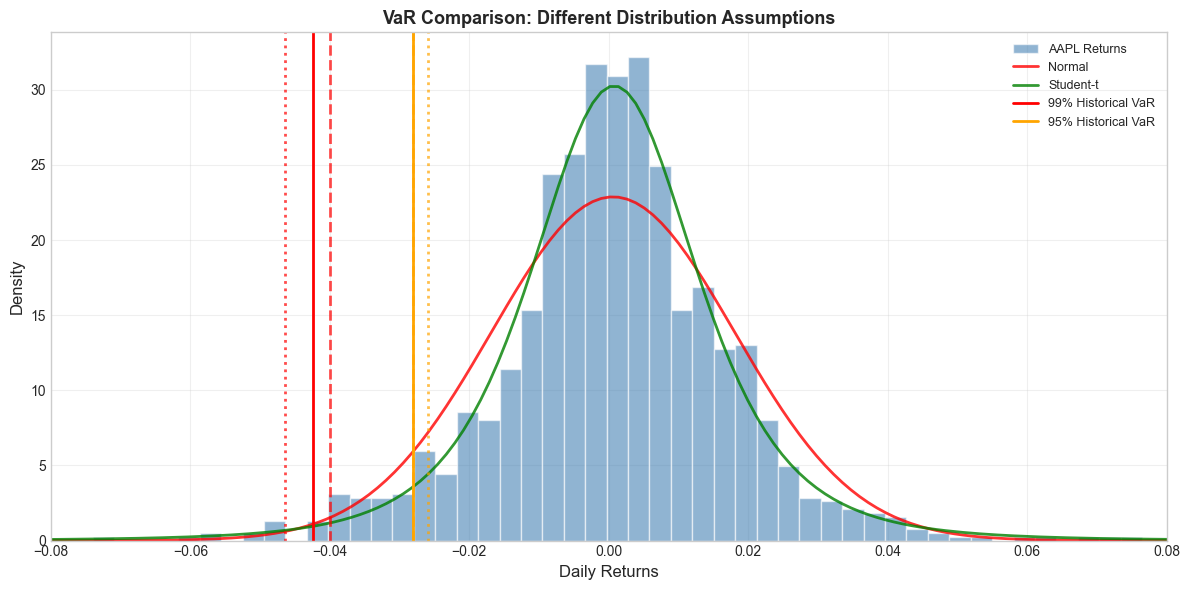


⚠️ Key Risk Insight:
   Normal VaR UNDERESTIMATES tail risk!
   Student-t or Historical VaR is more conservative.


In [5]:
# VaR Calculation: Comparing Distribution Assumptions
print("=" * 60)
print("VALUE AT RISK (VaR) - DISTRIBUTION COMPARISON")
print("=" * 60)

confidence_levels = [0.01, 0.05, 0.10]  # 99%, 95%, 90% confidence
portfolio_value = 1_000_000  # $1M portfolio

print(f"\nPortfolio Value: ${portfolio_value:,.0f}")
print("\n" + "-" * 60)
print(f"{'Confidence':<15} {'Historical':<15} {'Normal':<15} {'Student-t':<15}")
print("-" * 60)

var_results = {}
for alpha in confidence_levels:
    # Historical VaR (non-parametric)
    var_hist = np.percentile(aapl_returns, alpha * 100)
    
    # Normal VaR (parametric)
    var_normal = normal_dist.ppf(alpha)
    
    # Student-t VaR (parametric, fat tails)
    var_t = t_dist.ppf(alpha)
    
    var_results[alpha] = {
        'historical': var_hist,
        'normal': var_normal,
        'student_t': var_t
    }
    
    print(f"{1-alpha:.0%} VaR"
          f"         {var_hist:.2%}"
          f"          {var_normal:.2%}"
          f"          {var_t:.2%}")

print("\n" + "=" * 60)
print("VaR IN DOLLAR TERMS (1-Day)")
print("=" * 60)
print(f"\n{'Confidence':<15} {'Historical':<15} {'Normal':<15} {'Student-t':<15}")
print("-" * 60)

for alpha in confidence_levels:
    var_h = abs(var_results[alpha]['historical']) * portfolio_value
    var_n = abs(var_results[alpha]['normal']) * portfolio_value
    var_t = abs(var_results[alpha]['student_t']) * portfolio_value
    print(f"{1-alpha:.0%} VaR"
          f"         ${var_h:>10,.0f}"
          f"     ${var_n:>10,.0f}"
          f"     ${var_t:>10,.0f}")

# Visualize VaR
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(aapl_returns, bins=80, density=True, alpha=0.6, 
        color='steelblue', edgecolor='white', label='AAPL Returns')
ax.plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2, alpha=0.8, label='Normal')
ax.plot(x_range, t_dist.pdf(x_range), 'g-', lw=2, alpha=0.8, label='Student-t')

# Mark VaR levels
colors = ['red', 'orange', 'gold']
for i, alpha in enumerate([0.01, 0.05]):
    ax.axvline(var_results[alpha]['historical'], color=colors[i], 
               linestyle='-', lw=2, label=f'{1-alpha:.0%} Historical VaR')
    ax.axvline(var_results[alpha]['normal'], color=colors[i], 
               linestyle='--', lw=2, alpha=0.7)
    ax.axvline(var_results[alpha]['student_t'], color=colors[i], 
               linestyle=':', lw=2, alpha=0.7)

ax.set_xlabel('Daily Returns', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('VaR Comparison: Different Distribution Assumptions', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.08, 0.08)

plt.tight_layout()
plt.show()

print("\n⚠️ Key Risk Insight:")
print("   Normal VaR UNDERESTIMATES tail risk!")
print("   Student-t or Historical VaR is more conservative.")

## 5. Distribution Comparison Across Assets

Different assets exhibit different distributional properties. Let's compare AAPL, MSFT, GOOGL, and JPM.

DISTRIBUTION COMPARISON ACROSS ASSETS


Asset Mean (ann) Vol (ann) Skewness Kurtosis t-df Normal?
 AAPL     15.41%    27.68%    0.468    6.734 3.86      No
 MSFT     17.39%    25.66%    0.209    3.256 4.50      No
GOOGL     29.98%    31.03%    0.088    3.175 4.23      No
  JPM     22.14%    24.28%    0.094    5.096 4.22      No

💡 Interpretation Guide:
   Skewness: 0 = symmetric, < 0 = left skew (more crashes)
   Kurtosis: 0 = Normal, > 0 = fat tails (leptokurtic)
   t-df:     Lower = heavier tails (typically 3-5 for stocks)


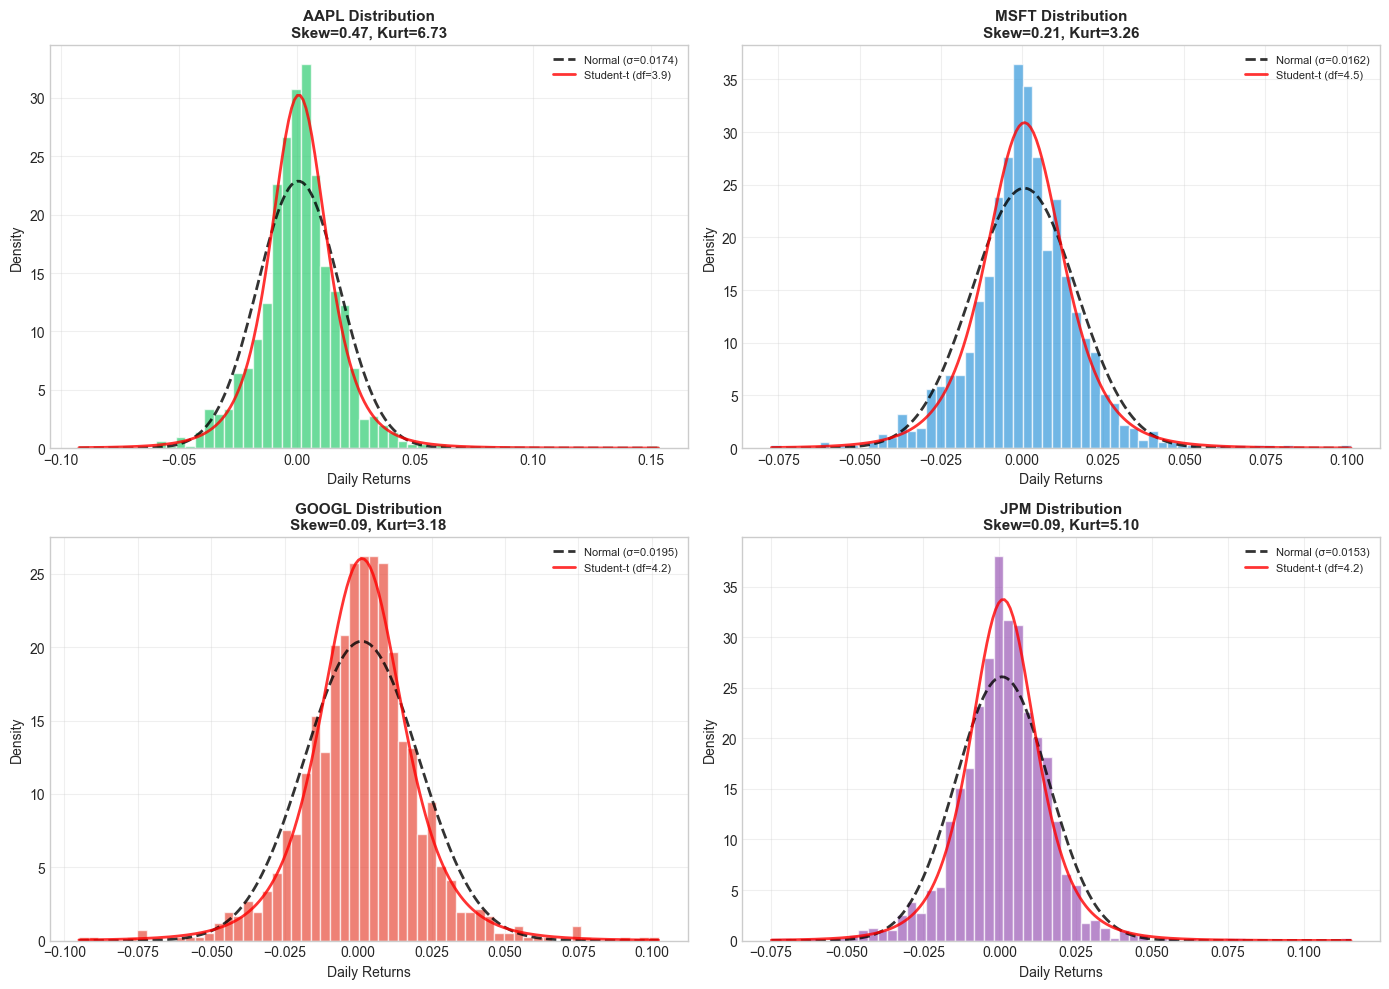

In [6]:
# Compare distributions across multiple assets
print("=" * 60)
print("DISTRIBUTION COMPARISON ACROSS ASSETS")
print("=" * 60)

assets = ['AAPL', 'MSFT', 'GOOGL', 'JPM']
results = []

for asset in assets:
    r = returns[asset].values
    
    # Basic stats
    mu = np.mean(r)
    sigma = np.std(r)
    skew = stats.skew(r)
    kurt = stats.kurtosis(r)  # Excess kurtosis (0 for Normal)
    
    # Fit Student-t
    df_t, _, _ = stats.t.fit(r)
    
    # Normality test
    _, p_val = stats.normaltest(r)
    
    results.append({
        'Asset': asset,
        'Mean (ann)': mu * 252,
        'Vol (ann)': sigma * np.sqrt(252),
        'Skewness': skew,
        'Kurtosis': kurt,
        't-df': df_t,
        'Normal?': 'Yes' if p_val > 0.05 else 'No'
    })

results_df = pd.DataFrame(results)
print("\n")
print(results_df.to_string(index=False, 
    formatters={
        'Mean (ann)': '{:.2%}'.format,
        'Vol (ann)': '{:.2%}'.format,
        'Skewness': '{:.3f}'.format,
        'Kurtosis': '{:.3f}'.format,
        't-df': '{:.2f}'.format
    }))

print("\n💡 Interpretation Guide:")
print("   Skewness: 0 = symmetric, < 0 = left skew (more crashes)")
print("   Kurtosis: 0 = Normal, > 0 = fat tails (leptokurtic)")
print("   t-df:     Lower = heavier tails (typically 3-5 for stocks)")

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, asset in enumerate(assets):
    r = returns[asset].values
    
    # Histogram
    axes[i].hist(r, bins=60, density=True, alpha=0.7, 
                 color=colors[i], edgecolor='white')
    
    # Normal fit
    mu, sigma = np.mean(r), np.std(r)
    x = np.linspace(r.min(), r.max(), 200)
    axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'k--', lw=2, 
                 label=f'Normal (σ={sigma:.4f})', alpha=0.8)
    
    # Student-t fit
    df_t, loc_t, scale_t = stats.t.fit(r)
    axes[i].plot(x, stats.t.pdf(x, df_t, loc_t, scale_t), 'r-', lw=2, 
                 label=f'Student-t (df={df_t:.1f})', alpha=0.8)
    
    axes[i].set_xlabel('Daily Returns', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].set_title(f'{asset} Distribution\nSkew={stats.skew(r):.2f}, Kurt={stats.kurtosis(r):.2f}', 
                      fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Practice Exercise: Distribution Analysis

**Challenge:** Analyze a portfolio of equal-weighted stocks and answer:
1. Does portfolio diversification make returns more Normal?
2. Calculate the 99% VaR using all three methods

PRACTICE: EQUAL-WEIGHTED PORTFOLIO ANALYSIS

Comparing Individual Assets vs Equal-Weight Portfolio:
--------------------------------------------------

Portfolio Stats:
  Annual Return:  21.23%
  Annual Vol:     21.27%
  Skewness:       0.273
  Kurtosis:       4.873
  Student-t df:   4.18
  Normal?         No

Diversification Effect:
  Avg Individual Vol: 27.16%
  Portfolio Vol:      21.27%
  Vol Reduction:      21.7%

  Avg Individual Kurt: 4.57
  Portfolio Kurt:      4.87
  Tail Risk Change:    Increased

99% VaR COMPARISON (Portfolio)

  Historical 99% VaR: -3.61%
  Normal 99% VaR:     -3.03%
  Student-t 99% VaR:  -3.50%


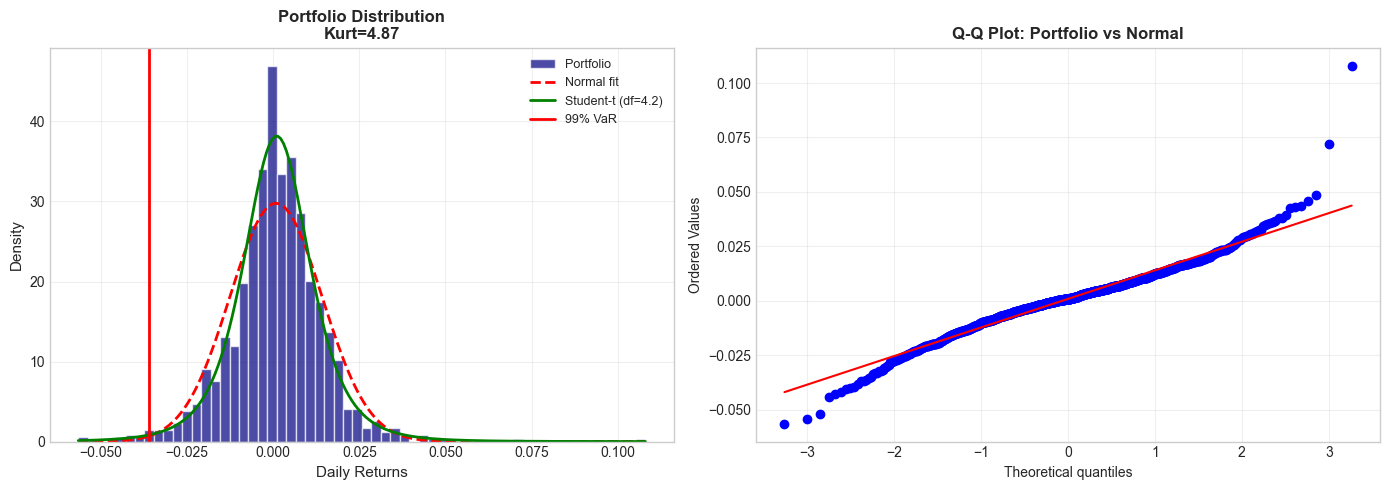


📊 Key Finding:
   Diversification reduces volatility but returns still have fat tails!


In [7]:
# Practice: Portfolio Distribution Analysis
print("=" * 60)
print("PRACTICE: EQUAL-WEIGHTED PORTFOLIO ANALYSIS")
print("=" * 60)

# Create equal-weighted portfolio returns
portfolio_returns = returns[assets].mean(axis=1).values

# Compare individual asset to portfolio
print("\nComparing Individual Assets vs Equal-Weight Portfolio:")
print("-" * 50)

# Portfolio stats
port_mu = np.mean(portfolio_returns)
port_sigma = np.std(portfolio_returns)
port_skew = stats.skew(portfolio_returns)
port_kurt = stats.kurtosis(portfolio_returns)
df_port, _, _ = stats.t.fit(portfolio_returns)
_, p_port = stats.normaltest(portfolio_returns)

# Average individual stats
avg_vol = np.mean([np.std(returns[a]) for a in assets])
avg_kurt = np.mean([stats.kurtosis(returns[a]) for a in assets])

print(f"\nPortfolio Stats:")
print(f"  Annual Return:  {port_mu * 252:.2%}")
print(f"  Annual Vol:     {port_sigma * np.sqrt(252):.2%}")
print(f"  Skewness:       {port_skew:.3f}")
print(f"  Kurtosis:       {port_kurt:.3f}")
print(f"  Student-t df:   {df_port:.2f}")
print(f"  Normal?         {'Yes' if p_port > 0.05 else 'No'}")

print(f"\nDiversification Effect:")
print(f"  Avg Individual Vol: {avg_vol * np.sqrt(252):.2%}")
print(f"  Portfolio Vol:      {port_sigma * np.sqrt(252):.2%}")
print(f"  Vol Reduction:      {(1 - port_sigma / avg_vol):.1%}")
print(f"\n  Avg Individual Kurt: {avg_kurt:.2f}")
print(f"  Portfolio Kurt:      {port_kurt:.2f}")
print(f"  Tail Risk Change:    {'Reduced' if port_kurt < avg_kurt else 'Increased'}")

# Portfolio VaR comparison
print("\n" + "=" * 60)
print("99% VaR COMPARISON (Portfolio)")
print("=" * 60)

# Fit distributions
port_normal = stats.norm(loc=port_mu, scale=port_sigma)
port_t = stats.t(*stats.t.fit(portfolio_returns))

var_hist = np.percentile(portfolio_returns, 1)
var_normal = port_normal.ppf(0.01)
var_t = port_t.ppf(0.01)

print(f"\n  Historical 99% VaR: {var_hist:.2%}")
print(f"  Normal 99% VaR:     {var_normal:.2%}")
print(f"  Student-t 99% VaR:  {var_t:.2%}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Portfolio distribution
axes[0].hist(portfolio_returns, bins=60, density=True, alpha=0.7, 
             color='navy', edgecolor='white', label='Portfolio')
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 200)
axes[0].plot(x, port_normal.pdf(x), 'r--', lw=2, label='Normal fit')
axes[0].plot(x, port_t.pdf(x), 'g-', lw=2, label=f'Student-t (df={df_port:.1f})')
axes[0].axvline(var_hist, color='red', lw=2, label='99% VaR')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title(f'Portfolio Distribution\nKurt={port_kurt:.2f}', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(portfolio_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Portfolio vs Normal', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Finding:")
print("   Diversification reduces volatility but returns still have fat tails!")

## 📝 Key Takeaways - Day 1

### Distribution Facts for Quant Interviews:

1. **Normal Distribution Fails**
   - Real returns have fat tails (leptokurtic)
   - Returns exhibit negative skewness
   - Volatility is not constant

2. **Student-t is More Realistic**
   - Captures fat tails with degrees of freedom parameter
   - Typical df = 3-5 for stock returns
   - More conservative VaR estimates

3. **Log-Normal for Prices**
   - If log returns ~ Normal, prices ~ Log-Normal
   - Foundation of Black-Scholes
   - Ensures prices stay positive

4. **VaR Implications**
   - Normal VaR underestimates tail risk
   - Historical VaR is non-parametric
   - Student-t VaR is more conservative

### Interview Questions to Prepare:
- "Why do we use log returns instead of simple returns?"
- "How do fat tails affect risk management?"
- "What's the difference between Normal and Student-t VaR?"
- "Does diversification eliminate tail risk?"

## 🔴 PROS & CONS: Probability Distributions

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Probability Distributions Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 12:18

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
